In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pyspark.sql import SparkSession
from DataVisualization import DataVisualization
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer


# Modelo de análise das métricas RFV:

Segmentando a base de clientes e personalizando as campanhas de marketing.

## DataFrame:

In [168]:
path = r'../data/data.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    decimal='.',
    sep=',',
    encoding='unicode_escape'
)

In [169]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Código:

In [170]:
class CustomerProfiles(DataVisualization):
    def gráfico_kelbow_visualizer(self, modelo, x, k: int):
        return kelbow_visualizer(modelo, x, k=k, timings=False)
    
    def clustering_k_means(self, model, x):
        model.fit(x)
        centroids = model.cluster_centers_
        labels = model.labels_
        inertia = model.inertia_
        predict = model.fit_predict(x)
        return centroids, labels, inertia, predict

    def gráfico_clusters_scatterplot3d(self, data: list, labels, figsize: tuple, titulo: str):
        plt.figure(figsize=figsize)
        plt.title(titulo)
        ax = plt.axes(projection='3d')
        fg = ax.scatter3D(data[0], data[1], data[2], s=60, c = labels,)

if __name__ == '__main__':
    customer_profiles = CustomerProfiles()

## Output:

### Data Understanding:

In [171]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [172]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [173]:
customer_profiles.verificando_as_dimensões_do_dataframe(
    dataframe=df
)

Linhas: 541909 
Colunas: 8


In [174]:
customer_profiles.verificando_tipos(
    dataframe=df
)

,Tipos
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [175]:
customer_profiles.descrição(
    dataframe=df
)

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


In [176]:
customer_profiles.verificando_valores_nulos(
    dataframe=df
)

,Quantidade,Porcentagem
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,1454,0.27%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,135080,24.93%
Country,0,0.00%


In [177]:
customer_profiles.verificando_valores_duplicados(
    dataframe=df
)

,Quantidade,Porcentagem
InvoiceNo,516009,95.22%
StockCode,537839,99.25%
Description,537685,99.22%
Quantity,541187,99.87%
InvoiceDate,518649,95.71%
UnitPrice,540279,99.70%
CustomerID,537536,99.19%
Country,541871,99.99%


### Data Visualization:

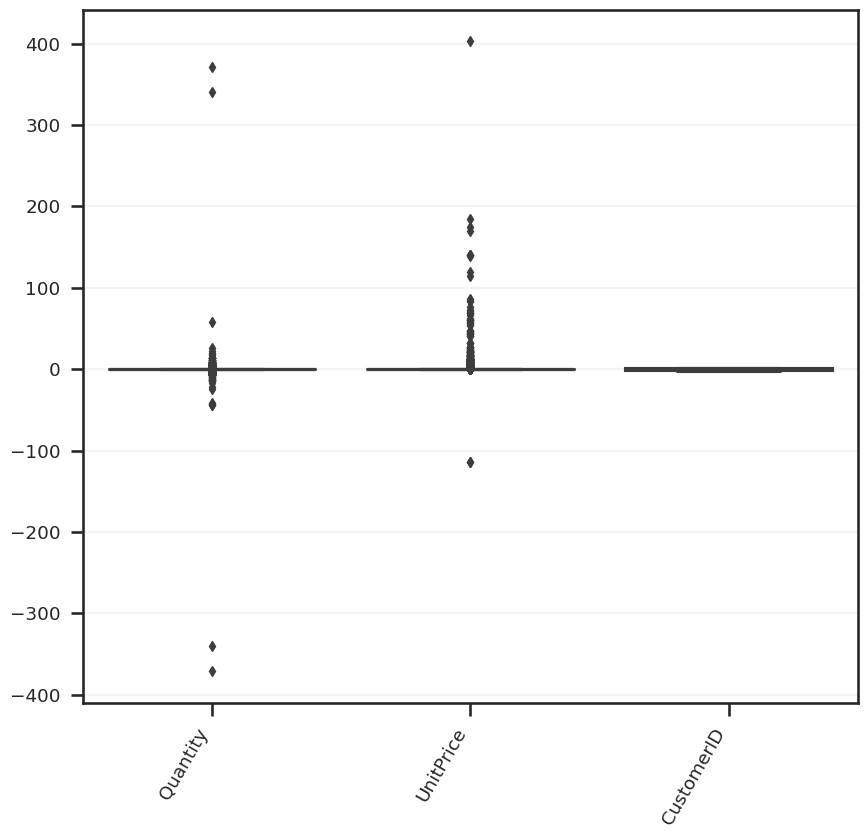

In [178]:
customer_profiles.gráfico_boxplot(
    dataframe=df,
    figsize=(10, 9)
)

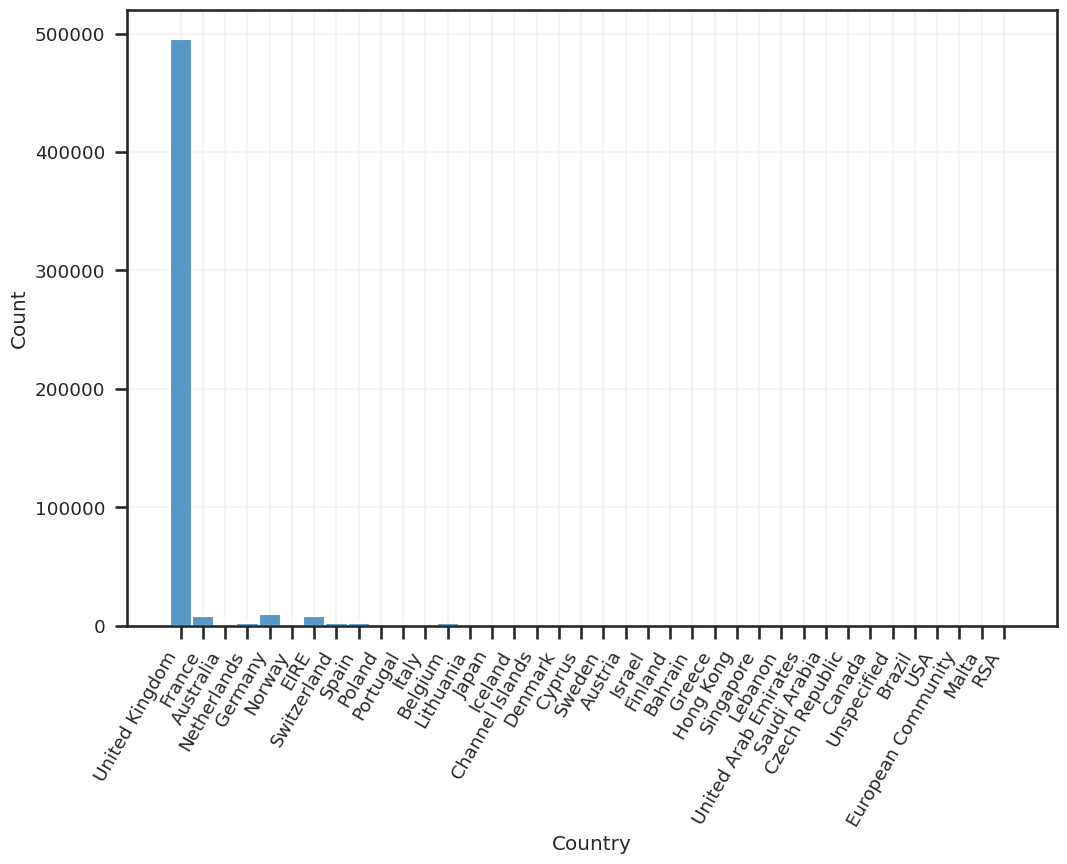

In [179]:
customer_profiles.gráfico_histplot(
    dataframe=df,
    coluna='Country'
)

### Data Preparetion:

In [180]:
df_copy = df.copy()

Removendo valores nulos:

In [181]:
df = customer_profiles.removendo_nulos(
    dataframe=df,
)

Convertendo a coluna 'CustomerID' para str:

In [182]:
colunas = ['CustomerID']

In [183]:
df[colunas] = customer_profiles.convertendo_colunas(
    dataframe=df,
    colunas=colunas,
    tipo='str'
)

Convertendo a coluna 'InvoiceDate' para Datetime:

In [184]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Análise RFV:

A sigla RFV significa Recency, Frequency, and Monetary Value, que são três métricas utilizadas para análise de clientes em estratégias de marketing.

- Recency (Recência) mede o tempo decorrido desde a última interação do cliente com a empresa, como uma compra ou uma visita ao site. Clientes mais recentes podem ter maior probabilidade de responder a promoções ou ofertas.

- Frequency (Frequência) indica a frequência com que um cliente realiza transações ou interações com a empresa em um determinado período de tempo. Clientes mais frequentes podem ser considerados mais engajados e valiosos.

- Monetary Value (Valor Monetário) representa o valor total gasto por um cliente em um determinado período. Clientes de alto valor monetário podem ser segmentados de forma diferente e receber um tratamento especial.

#### Recency:

Obtendo a data mais recente presente no dataframe:

In [185]:
data_mais_recente = df['InvoiceDate'].max()

In [186]:
display(data_mais_recente)

Timestamp('2011-12-09 12:50:00')

Calculando a recência em dias:

In [187]:
df_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_recency['Recency'] = (data_mais_recente - df_recency['InvoiceDate']).dt.days
df_recency = df_recency.drop('InvoiceDate', axis=1)

In [188]:
display(df_recency.head(3))

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74


#### Frequency:

In [189]:
df_frequency = df.groupby('CustomerID').agg({'InvoiceDate': 'count'}).reset_index()
df_frequency = df_frequency.rename(columns={'InvoiceDate': 'Frequency'})

In [190]:
display(df_frequency.head(3))

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31


#### Monetary value:

In [191]:
df_monetary_value = df
df_monetary_value['MonetaryValue'] = df['Quantity'] * df['UnitPrice']
df_monetary_value = df_monetary_value.groupby('CustomerID').agg({'MonetaryValue': 'sum'}).reset_index()

In [192]:
display(df_monetary_value.head(3))

,CustomerID,MonetaryValue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24


#### RFV:

Merge:

In [193]:
# Primeiro merge entre df_recency e df_frequency
df_rfv = pd.merge(df_recency, df_frequency, on='CustomerID', how='inner')

# Merge resultante com df_monetary_value
df_rfv = pd.merge(df_rfv, df_monetary_value, on='CustomerID', how='inner')

In [194]:
display(df_rfv.head(3))

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24


### Data Visualization:

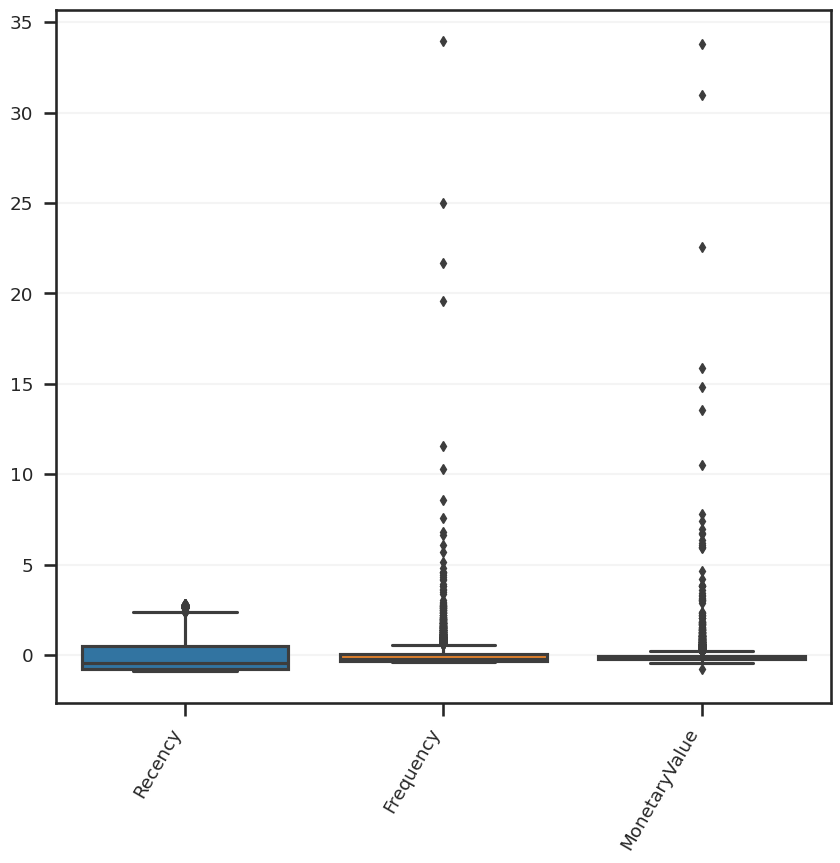

In [195]:
customer_profiles.gráfico_boxplot(
    dataframe=df_rfv,
    figsize=(10, 9)
)

In [196]:
colunas = ['Recency', 'Frequency', 'MonetaryValue']

Recency:


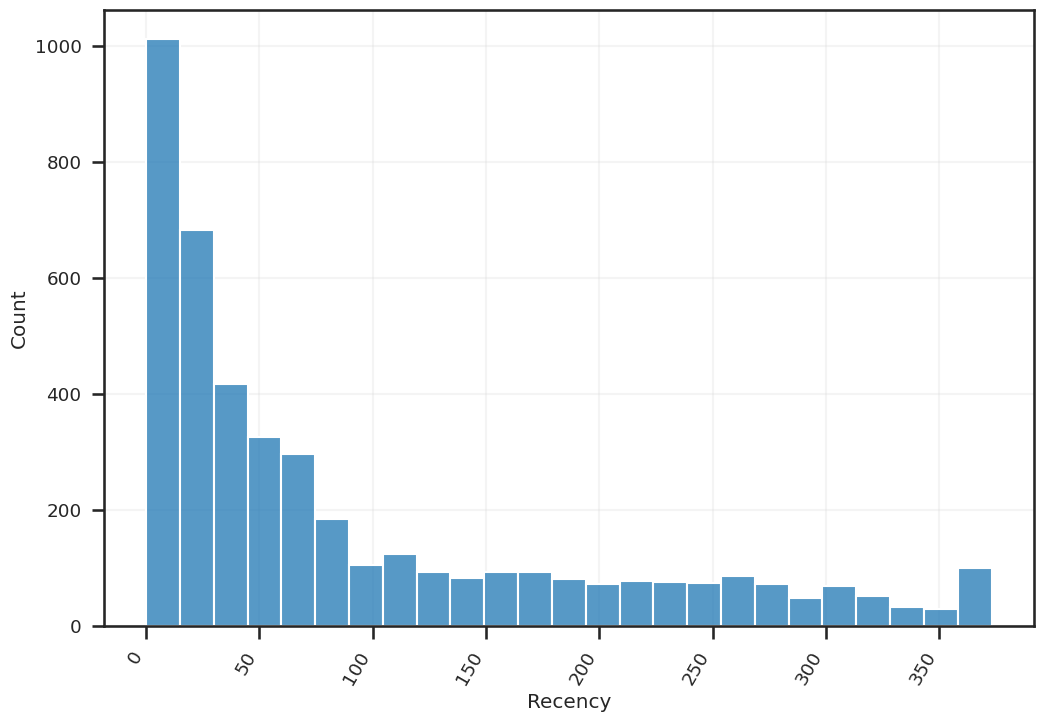

Frequency:


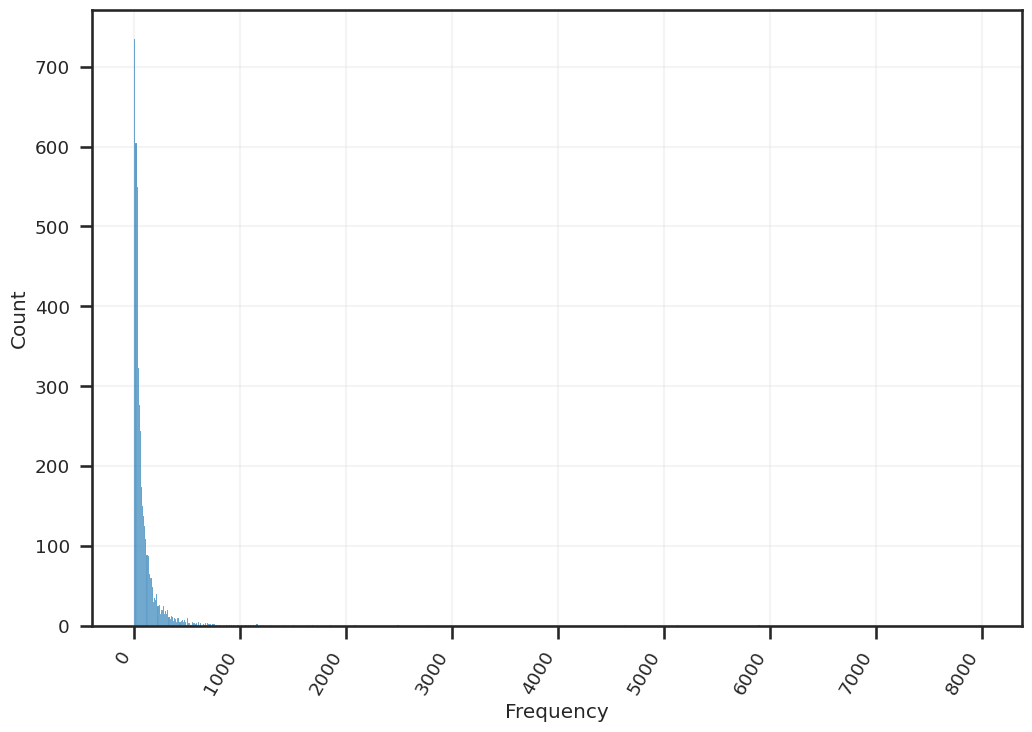

MonetaryValue:


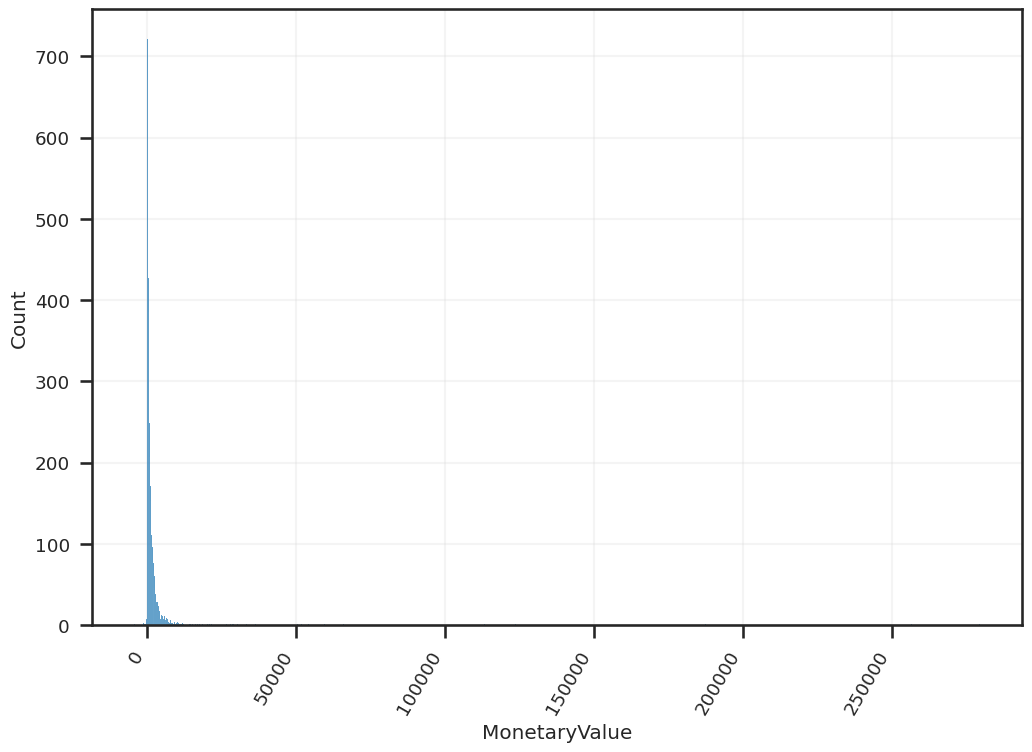

In [197]:
for coluna in colunas:
    print(f'{coluna}:')
    customer_profiles.gráfico_histplot(
        dataframe=df_rfv,
        coluna=coluna
    )

### Data Preparetion:

Colunas númericas:

In [198]:
colunas = ['Recency', 'Frequency', 'MonetaryValue']

Normalizando os dados:

In [199]:
for coluna in colunas:
    df_rfv[coluna] = customer_profiles.normalizando_os_dados(
        dataframe=df_rfv[coluna]
    )

Removendo nulos:

In [200]:
df_rfv = customer_profiles.removendo_nulos(
    dataframe=df_rfv
)

#### Testando técnicas de remoção de outliers:

In [201]:
# def remove_outliers_zscore(df, coluna, limite=3):
#     z_scores = np.abs((df[coluna] - df[coluna].mean()) / df[coluna].std())
#     df_sem_outliers = df[z_scores < limite]
#     return df_sem_outliers[coluna]

# for coluna in colunas:
#     print(coluna)
#     df_rfv[coluna] = remove_outliers_zscore(df=df_rfv, coluna=coluna, limite=3)

In [202]:
# def remove_outliers_teste_estatistico(df, coluna, limite=3):
#     outliers = stats.zscore(df[coluna])
#     outliers_indices = np.where(np.abs(outliers) > limite)[0]
#     df_sem_outliers = df.drop(outliers_indices)
#     return df_sem_outliers[coluna]

# for coluna in colunas:
#     print(coluna)
#     df_rfv[coluna] = remove_outliers_teste_estatistico(df=df_rfv, coluna=coluna, limite=3)

In [203]:
def remove_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
    return df_sem_outliers[coluna]

for coluna in colunas:
    print(coluna)
    df_rfv[coluna] = remove_outliers_iqr(df=df_rfv, coluna=coluna)

Recency
Frequency
MonetaryValue


Removendo nulos:

In [204]:
df_rfv = customer_profiles.removendo_nulos(
    dataframe=df_rfv
)

### Data Visualization:

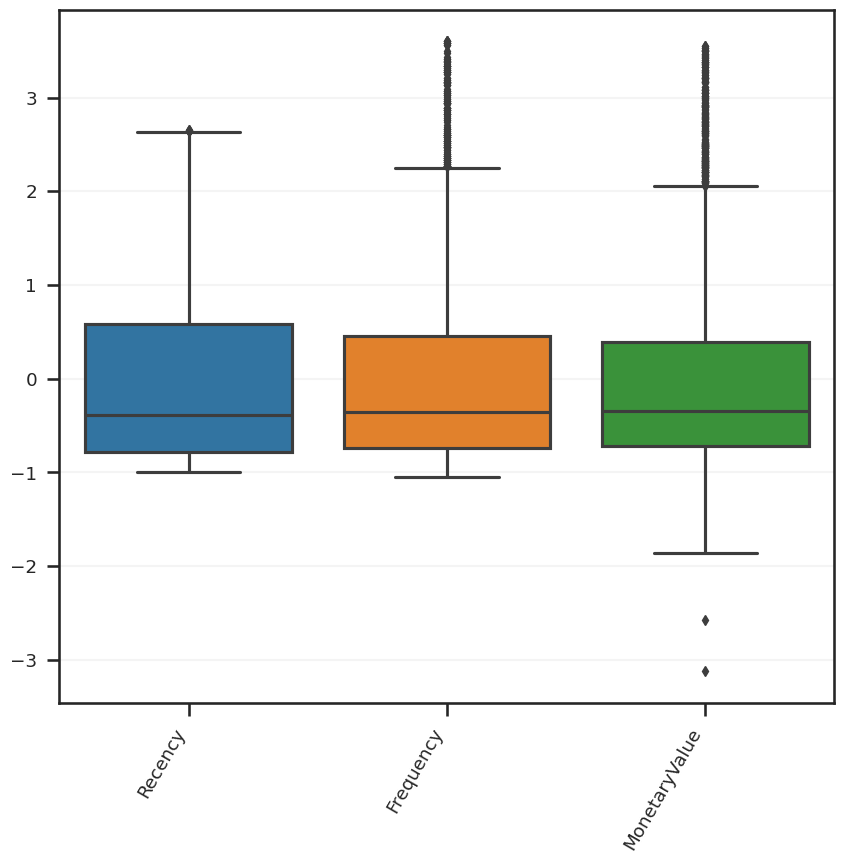

In [205]:
customer_profiles.gráfico_boxplot(
    dataframe=df_rfv,
    figsize=(10, 9)
)

Recency:


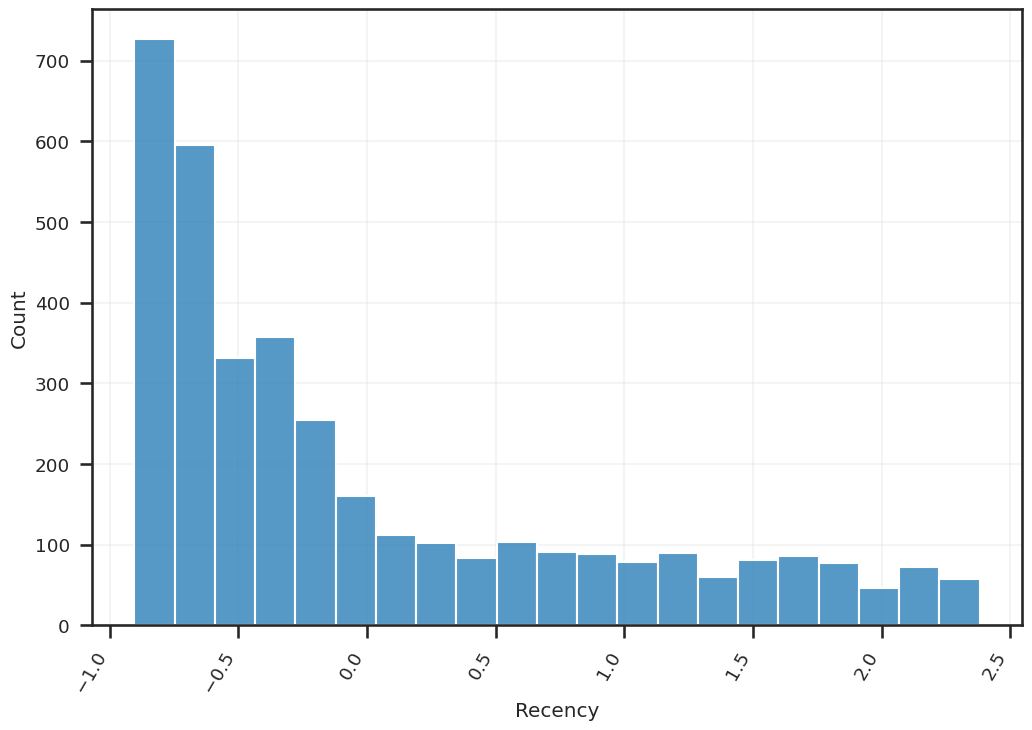

Frequency:


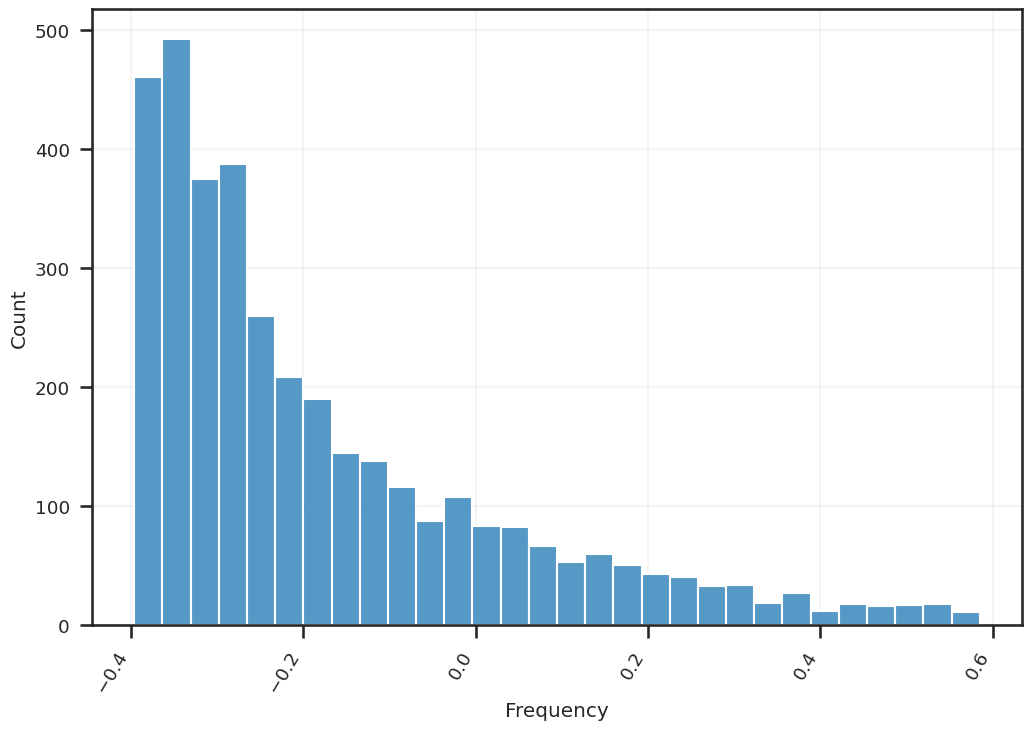

MonetaryValue:


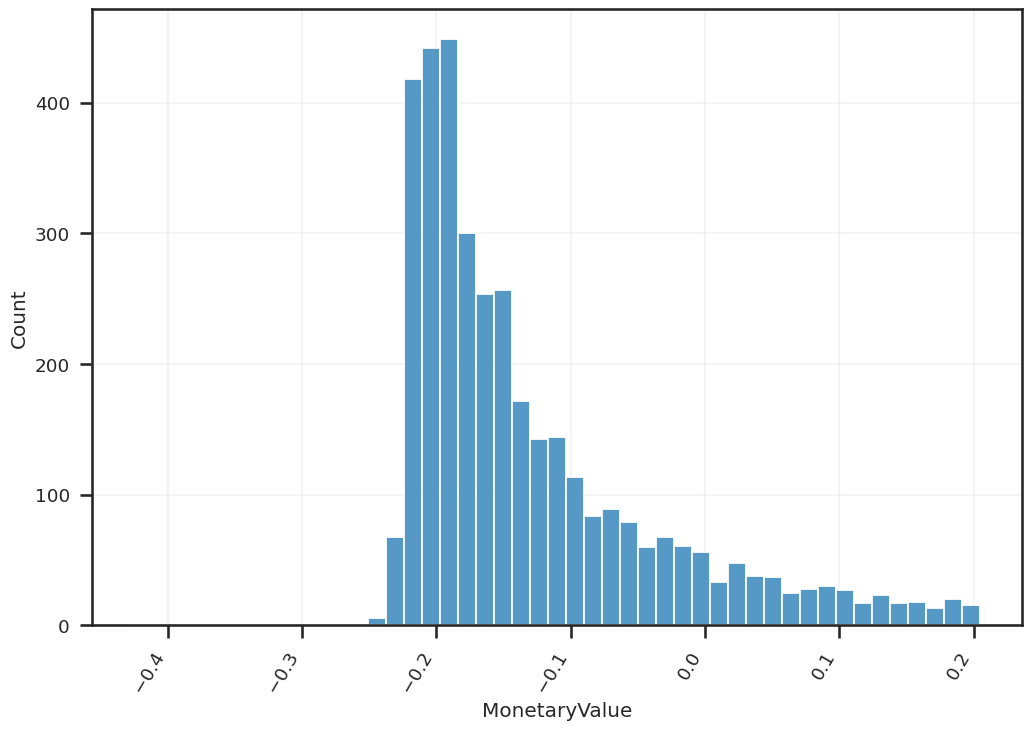

In [206]:
for coluna in colunas:
    print(f'{coluna}:')
    customer_profiles.gráfico_histplot(
        dataframe=df_rfv,
        coluna=coluna
    )

### Clustering:

K-means:

O algoritmo K-means possui algumas vantagens distintas em relação a outros modelos de clusterização, como o DBSCAN, a hierarquia e o Mean Shift. Aqui estão algumas vantagens do K-means:

- Simplicidade: O K-means é um algoritmo de clusterização relativamente simples de entender e implementar. Ele é baseado no conceito de centróides e cálculos de distância.

- Eficiência computacional: O K-means é um algoritmo eficiente e escalável, especialmente para grandes conjuntos de dados. Sua complexidade computacional é linear em relação ao número de pontos de dados e ao número de clusters.

- Interpretabilidade: O resultado do K-means é facilmente interpretável, uma vez que cada ponto de dados é atribuído a um cluster específico. Isso permite uma compreensão intuitiva das estruturas e padrões encontrados nos dados.

- Flexibilidade: O K-means pode ser usado com diferentes métricas de distância e funciona bem com dados numéricos contínuos. Ele também pode ser adaptado para lidar com dados categóricos por meio de técnicas de codificação apropriadas.

- Escalabilidade: O K-means é adequado para grandes conjuntos de dados, pois seu desempenho não é afetado pelo aumento do número de observações. Isso o torna útil em cenários onde há um grande número de dados a serem clusterizados.

No entanto, é importante ressaltar que cada algoritmo de clusterização tem suas próprias vantagens e desvantagens.

In [207]:
modelo = KMeans()

In [208]:
x = df_rfv[colunas]

/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

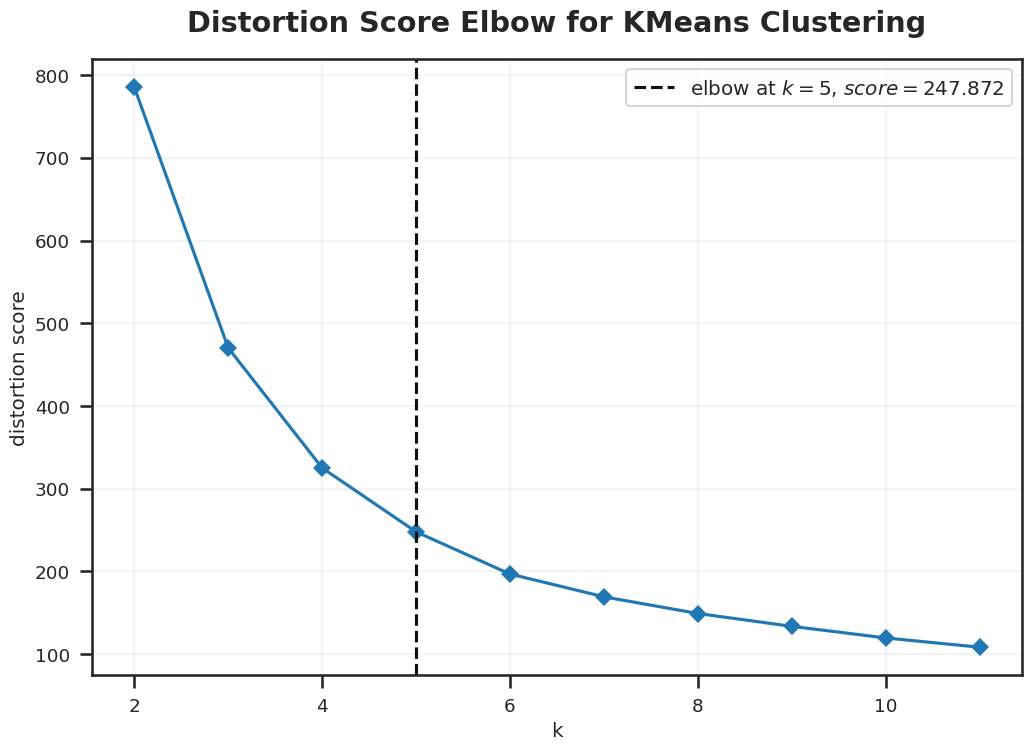

In [209]:
customer_profiles.gráfico_kelbow_visualizer(
    modelo=modelo,
    x=x,
    k=11
);

Criando os clusters:

In [210]:
modelo = KMeans(n_clusters=5, init='k-means++', random_state=37)

In [211]:
centroids, labels, inertia, predict = customer_profiles.clustering_k_means(
    model=modelo,
    x=x
)

/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/guerrlr0/anaconda3/envs/.cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visualizando os clusters:

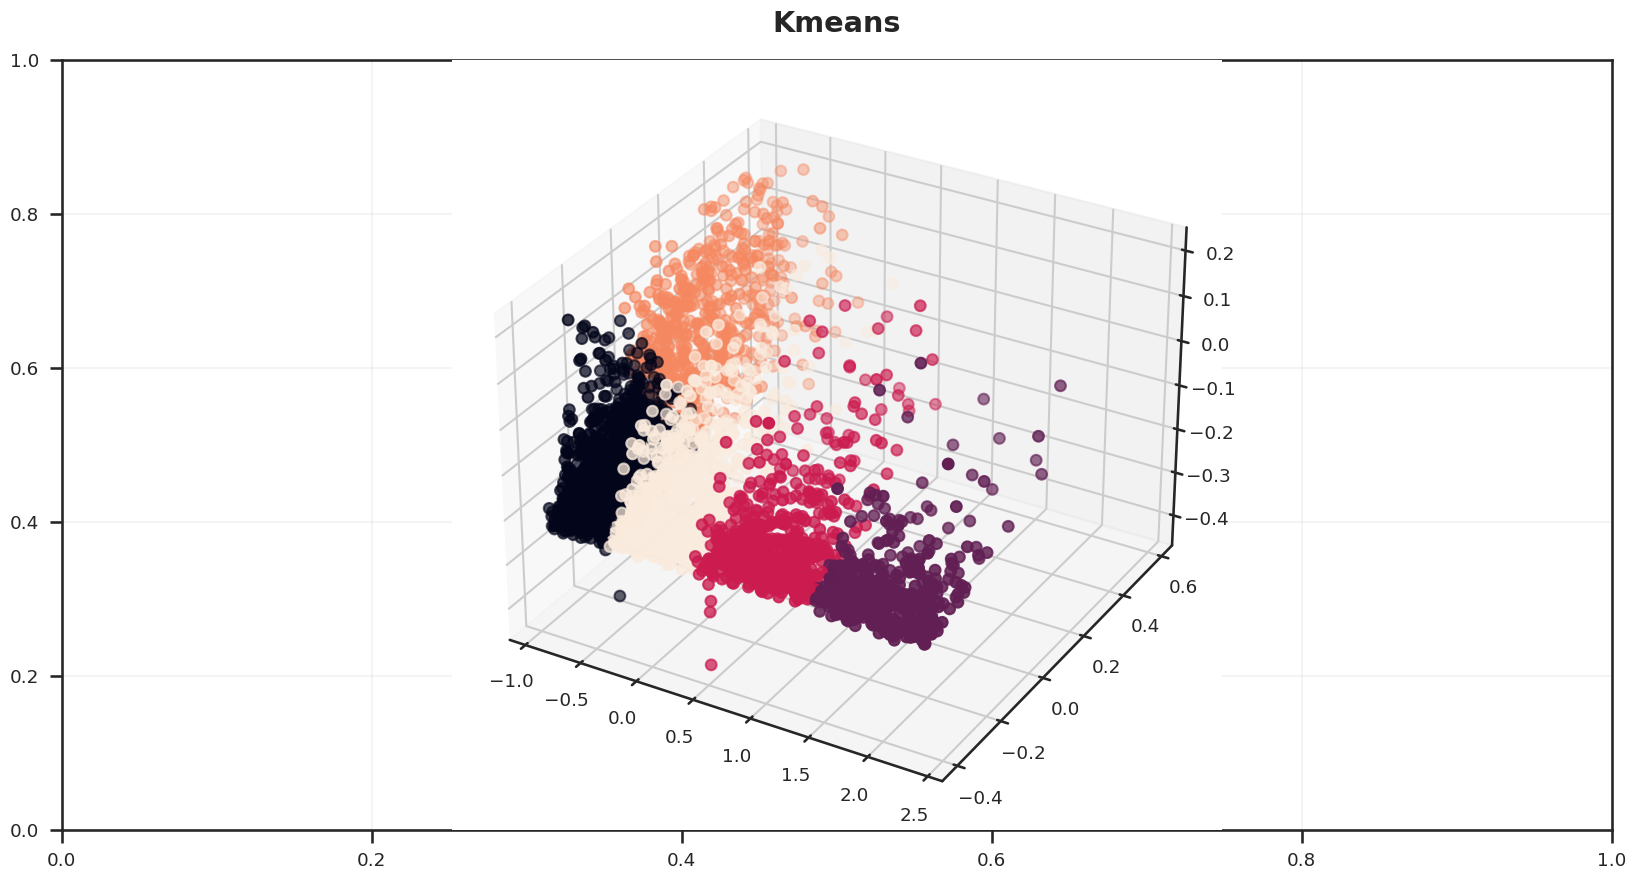

In [212]:
customer_profiles.gráfico_clusters_scatterplot3d(
    data=[df_rfv['Recency'],df_rfv['Frequency'],df_rfv['MonetaryValue']],
    labels=labels,
    figsize=(20,10),
    titulo='Kmeans'
)

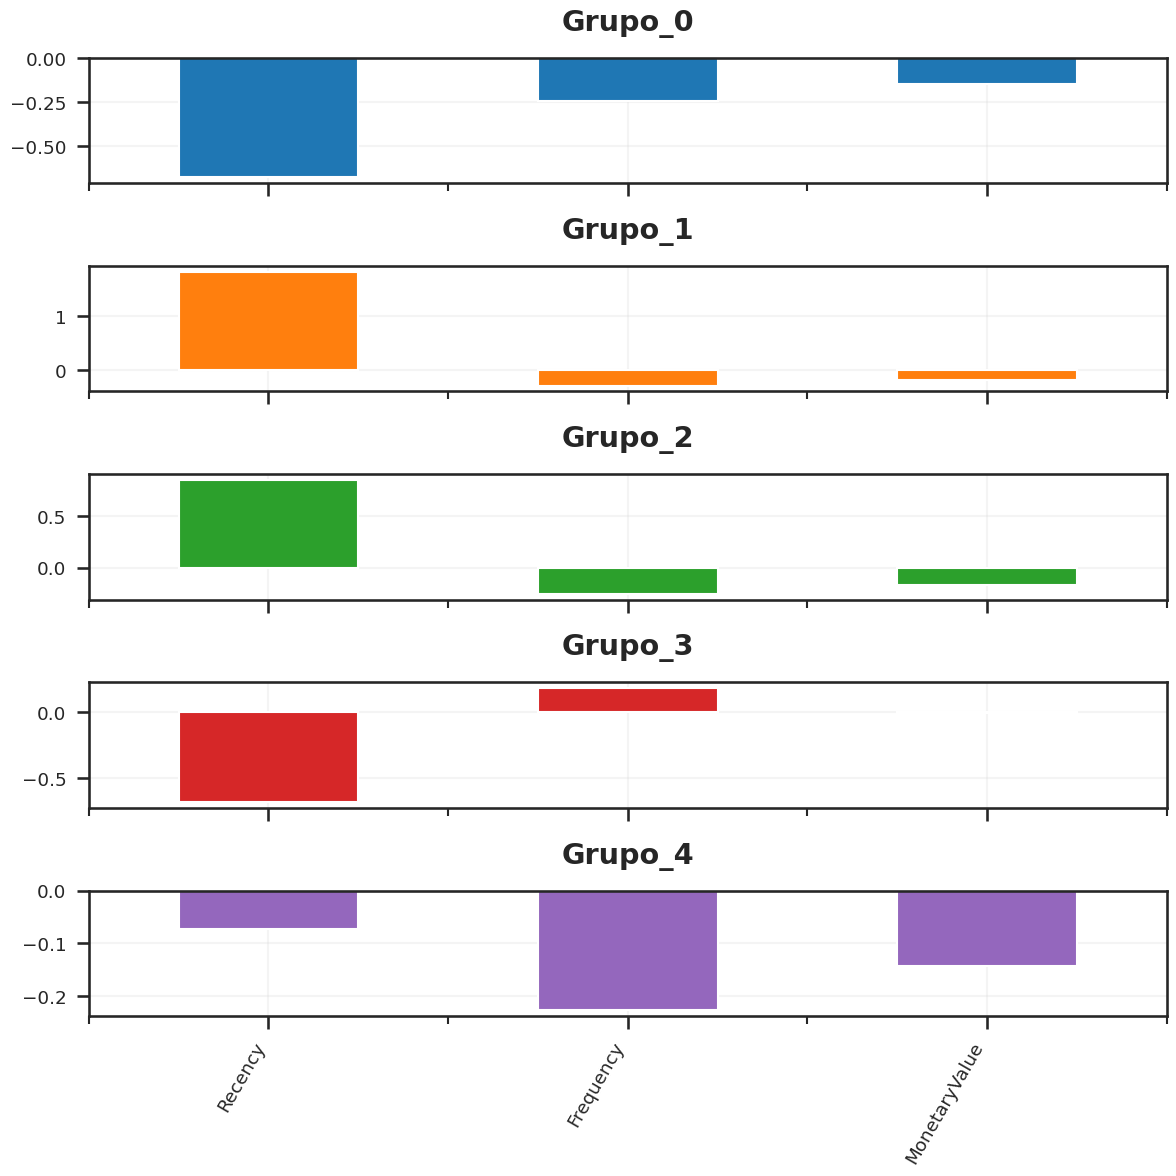

In [213]:
(
  pd.DataFrame(centroids, columns=colunas)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [214]:
centers = pd.DataFrame(centroids, columns=colunas)
display(centers)

,Recency,Frequency,MonetaryValue
0,-0.674627,-0.242133,-0.148516
1,1.836678,-0.299579,-0.184971
2,0.853920,-0.256386,-0.167259
3,-0.681338,0.181397,-0.008031
4,-0.072727,-0.225998,-0.142215


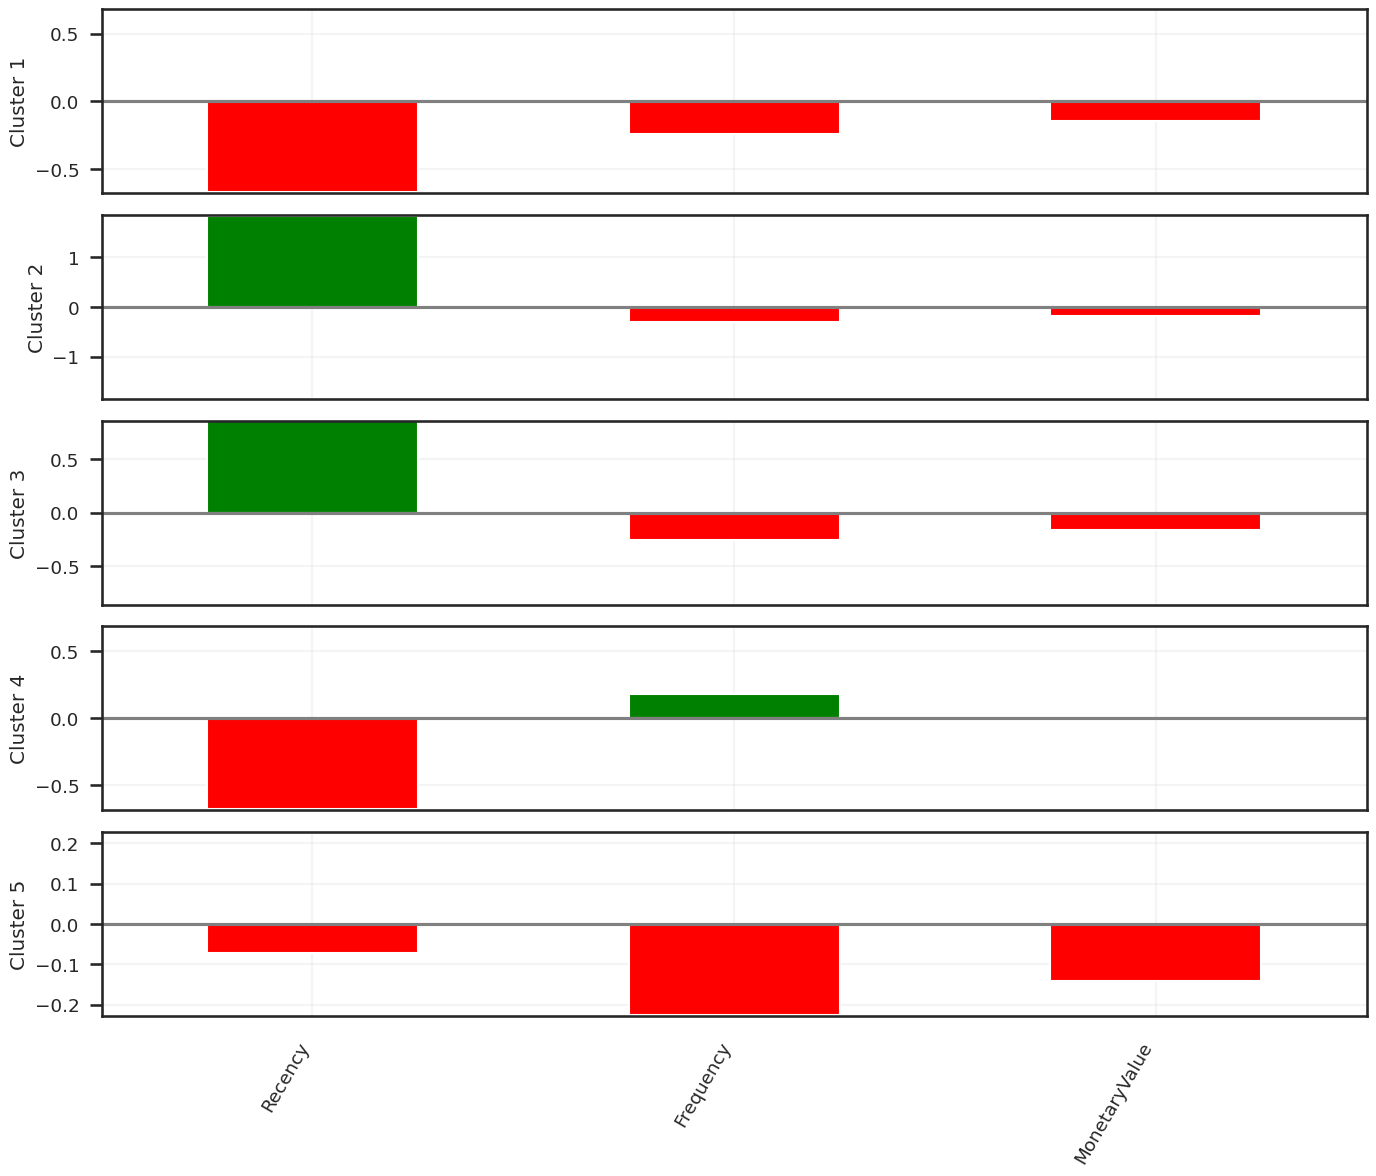

In [215]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig, axes = plt.subplots(nrows=5, figsize=(14,12), sharex=True)

for i, ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [216]:
(
  df_rfv[colunas].assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3,4
Recency,-0.674748,1.836678,0.853920,-0.681112,-0.072727
Frequency,-0.241974,-0.299579,-0.256386,0.181759,-0.225998
MonetaryValue,-0.148424,-0.184971,-0.167259,-0.007987,-0.142215


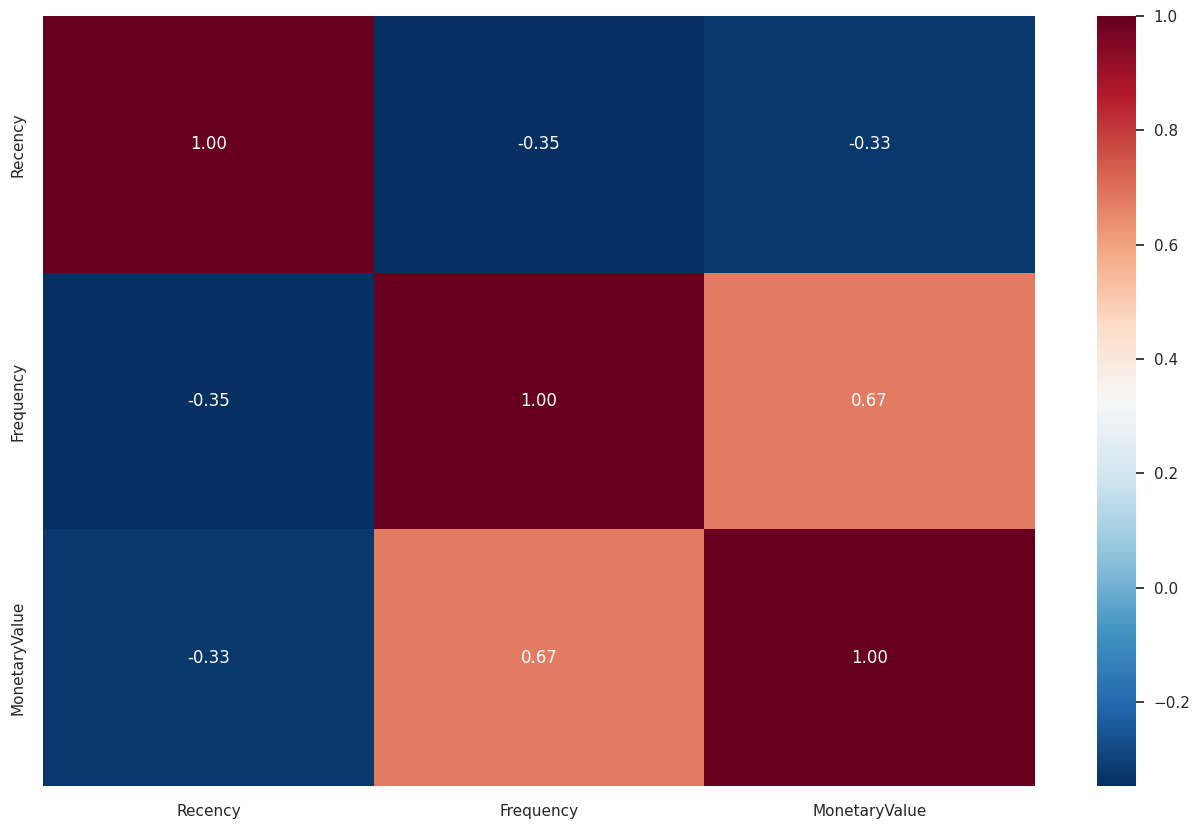

In [217]:
customer_profiles.gráfico_heatmap(
    dataframe=df_rfv[colunas]
)

## Avaliação:
Com o objetivo de identificar e segmentar os perfis dos clientes com base em seu padrão de compra, a fim de promover campanhas de marketing mais personalizadas, chegamos a 5 grupos distintos, representando 5 perfis de clientes.

- Perfil 1: O perfil 1 apresenta a pior recência em relação aos demais, indicando que esses clientes estão afastados de nossa plataforma há mais tempo. No entanto, o perfil 1 não difere muito dos perfis 4 e 5 em relação à recência. Além disso, a frequência de acesso à nossa plataforma por parte desse perfil também é baixa, sendo a segunda mais baixa, ficando atrás apenas do perfil 5.

- Perfil 2: O perfil 2 é composto por clientes que tiveram interações muito recentes em nossa plataforma. Portanto, é importante manter esses clientes interessados em nosso e-commerce, seja por meio de anúncios de produtos relevantes que possam resolver seus problemas ou proporcionar diversão. Em resumo, o perfil 2 apresenta excelente recência, frequência adequada e gastos moderados.

- Perfil 3: O perfil 3 também é composto por clientes que entraram em contato recentemente com nossa plataforma. Eles possuem excelente recência, frequência adequada e gastos moderados.

- Perfil 4: O perfil 4 é o perfil de cliente mais engajado que temos. Apresenta recência adequada, frequência excelente e gastos consideráveis. Em suma, o perfil 4 é extremamente valioso, e cada centavo investido nesse grupo vale a pena.

- Perfil 5: O perfil 5 representa nosso perfil de cliente mais inativo. Possui recência satisfatória, frequência baixa e gastos reduzidos. Trata-se de um perfil de cliente com pouca interação e, consequentemente, baixo volume de compras.

Conclusão: Nosso principal objetivo é criar uma campanha de marketing mais personalizada, lembrando que, no final, tudo se resume a vender. Um padrão identificado foi que os clientes que mais gastam em nossa plataforma são aqueles que a frequentam com mais regularidade. Portanto, uma ideia interessante seria criar estratégias para incentivar o cliente a visitar nossa plataforma e interagir. Por exemplo, podemos oferecer um desconto de 25% a partir da compra do 3º item ou promover descontos especiais nas sextas-feiras para clientes fiéis, a fim de fidelizá-los.